In [2]:
from github import Github
import urllib.request
import parser
import ast
import collections
import webbrowser
from lib2to3.refactor import RefactoringTool, get_fixers_from_package
import json
import pandas as pd

columns = ['name', 'commits', 'last_commit',  'contributors', 'releases', 'downloads', 'stars', 'watch', 'forks', 'impl', 'lib', 'functions', 'variables']
df = pd.DataFrame(columns=columns)
c = collections.Counter()


In [3]:
def impl(libs):
    impl=''
    if ('tensorflow' in libs): impl = 'tensorflow'
    elif ('theano' in libs): impl = 'theano'
    elif ('torch' in libs): impl = 'torch'
    elif ('Keras' in libs): impl = 'keras'
    elif ('mxnet' in libs): impl = 'mxnet'
    elif ('cntk' in libs): impl = 'cntk'
    elif ('caffe' in libs): impl = 'caffe'
    elif ('somoclu' in libs): impl = 'somoclu'
    elif ('mvpa2' in libs): impl = 'mvpa2'
    elif ('minisom' in libs): impl = 'minisom'
    elif ('sompy' in libs): impl = 'sompy'
    elif ('numpy' in libs): impl = 'numpy'
    else: impl = 'pure python'
    return  impl

def convertJtoP(code):
    converted = ''
    code = json.loads(code)
    for cell in code['cells']:
        if cell['cell_type'] == 'code':
            for line in cell['source']:
                if line[0] != '%': converted = converted + line + '\r\n'
    return converted

def getparse(code):
    try:
        return ast.parse(code)
    except:
        try:
            refactoring_tool = RefactoringTool(fixer_names=get_fixers_from_package('lib2to3.fixes'))
            code = refactoring_tool.refactor_string(code, 'script')
            return ast.parse(str(code))        
        except:
            print('parser error')
            return None  
    
def getlibs(code, jp):
    el = set()
    var = set()
    func = set()

    try:
        code = code.decode("utf8") + '\r\n'
    except:
        print("can't decode in utf8")
    
    if jp: code = convertJtoP(code)
    
    root = getparse(code)
    if root!=None:
        for node in ast.walk(root):
            if type(node) == ast.Import:
                for alias in node.names:
                    el.add( alias.name.split('.')[0])
            if type(node) == ast.ImportFrom:
                if (node.module != None):
                    el.add(node.module.split('.')[0])
            if isinstance(node, ast.Name):
                var.add(node.id)
            if isinstance(node, ast.FunctionDef):
                func.add(node.name)    
        return [el, func, var]
    else:
        return None
    
def getData(repositories):
    global df, c
    keywords = ['som','SOM', 'organizing', 'organize', 'kohonen', 'train', 'weight']
    
    i = 0
    for repo in repositories:
        full_name = repo.full_name
        files = set()
        libs = set()
        variables = set()
        functions = set()
        contents = repo.get_contents("")
        while len(contents) > 0:
            file_content = contents.pop(0)
            if file_content.type == "dir":
                contents.extend(repo.get_contents(file_content.path))
            else:
                if file_content.path.endswith('.py') or file_content.path.endswith('.ipynb'):
                    #print(('https://raw.githubusercontent.com/'+repo.full_name+'/master/'+file_content.path).replace(" ","%20"))
                    code = urllib.request.urlopen(('https://raw.githubusercontent.com/'+full_name+'/master/'+file_content.path).replace(" ","%20")).read()
                    files.add(file_content.path[file_content.path.rfind('/')+1:-3])
                    if any(c in str(code) for c in keywords):
                        jp = False
                        if file_content.path.endswith('.ipynb'): jp=True
                        l = getlibs(code, jp)
                        if (l!=None):
                            libs.update(l[0]) 
                            functions.update(l[1])
                            variables.update(l[2])
                        else:
                            print(('https://raw.githubusercontent.com/'+full_name+'/master/'+file_content.path).replace(" ","%20"))
        using_libs = libs-files
        c.update(using_libs) 
        df = df.append({'name': full_name, 'commits':repo.get_commits().totalCount, 
                        'last_commit':repo.get_commits()[0].commit.author.date,  
                        'contributors':repo.get_contributors().totalCount, 'releases':repo.get_releases().totalCount, 
                        'downloads':repo.get_downloads().totalCount, 'stars':repo.stargazers_count, 
                        'watch':repo.subscribers_count, 'forks':repo.forks_count, 'impl':impl(libs), 'lib':libs,
                        'functions':len(functions), 'variables':len(variables)}, ignore_index=True)
     
        i=i+1
        print(i, full_name)
        #if i>5: break

In [ ]:
g = Github("mthesis@yandex.ru", "jk7678977")
getData(g.search_repositories(query='Self organizing map language:python'))
getData(g.search_repositories(query='Self organizing map language:jupyter-notebook'))
df.to_excel('repo_info.xlsx')

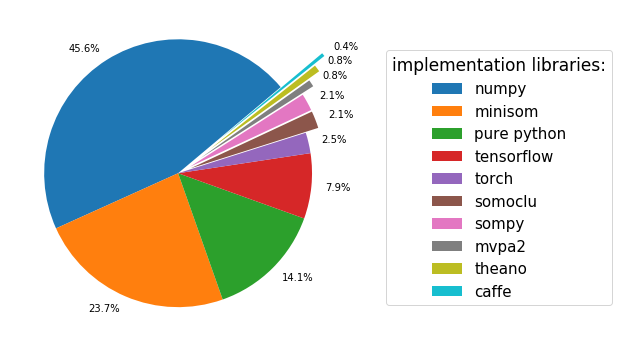

In [3]:
import matplotlib.pyplot as plt

df = pd.read_excel('repo_info.xlsx')
                   
counts = df['impl'].value_counts()
labels = ["{:.1f}%".format(i/sum(counts)*100,2) for i in counts]

plt.figure(figsize=(6, 6))
plt.axis('equal')
explode = ( 0, 0, 0, 0, 0, 0.1, 0.1, 0.2, 0.3, 0.4)

plt.pie(counts.values, labels=labels, explode=explode, startangle=40)
leg = plt.legend(labels=counts.index,loc='best',fontsize=15, bbox_to_anchor=(1.1, 0.4, 0.5, 0.5))
leg.set_title('implementation libraries:', prop = {'size':'17'})

plt.savefig('github_info.png',bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

In [18]:
df.sort_values(by='commits', ascending=False)

,name,commits,last_commit,contributors,releases,downloads,stars,watch,forks,impl,lib,functions,variables
137,meder411/som-pytorch,586,2018-04-19 23:59:25,1,0,0,1,1,0,torch,"{'som_utils', 'numpy', 'torch', 'abc', 'som', ...",16,91
198,sevamoo/SOMPY,182,2018-10-16 06:17:34,14,0,0,305,33,158,sompy,"{'urllib3', 'view', 'collections', 'itertools'...",36,288
1,JustGlowing/minisom,177,2019-01-09 09:40:15,4,4,0,258,22,89,minisom,"{'collections', 'sklearn', 'unittest', 'stop_w...",55,241
5,stephantul/somber,175,2018-10-17 16:43:21,1,0,0,26,4,7,numpy,"{'collections', 'types', 'json', 'Cython', 'lo...",36,158
9,mpatacchiola/pyERA,128,2018-04-21 11:46:12,1,0,0,39,8,17,tensorflow,"{'reinforcement_learning', 'PIL', 'threading',...",65,387
161,enry12/growing_hierarchical_som,127,2018-05-11 12:40:53,2,0,0,3,2,0,numpy,"{'progressbar', 'numpy', 'collections', 'queue...",54,198
22,njali2001/popsom,93,2018-12-13 17:14:21,1,0,0,2,2,0,numpy,"{'numpy', 'statsmodels', 'pandas', 'sklearn', ...",42,249
7,DiegoVicen/ntnu-som,67,2016-12-08 20:43:48,2,0,0,20,2,7,pure python,"{'random', 'helper', 'operator', 'functools', ...",7,56
0,DiegoVicen/som-tsp,62,2018-06-10 11:39:14,3,0,0,822,43,143,numpy,"{'io_helper', 'numpy', 'neuron', 'plot', 'sys'...",2,29
111,joaobarbirato/python-SOM-MLL,61,2018-08-29 00:10:35,1,0,0,1,1,0,numpy,"{'arff', 'kfold', 'sklearn', 'random', 'metric...",14,119


In [21]:
#NNNNNNNNNNNUUUUUUUMMMPPPYYY
code = urllib.request.urlopen('https://raw.githubusercontent.com/njali2001/popsom/master/popsom.py').read()
a,b,c = getlibs(code, False)
print('numpy-1',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/ramarlina/som/master/som.py').read()
a,b,c = getlibs(code, False)
print('numpy-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/stephantul/somber/master/somber/som.py').read()
a,b,c = getlibs(code, False)
print('numpy-3',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/stephantul/somber/master/somber/base.py').read()
a,b,c = getlibs(code, False)
print('numpy-3',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/stephantul/somber/master/somber/components/utilities.py').read()
a,b,c = getlibs(code, False)
print('numpy-3',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/stephantul/somber/master/somber/components/initializers.py').read()
a,b,c = getlibs(code, False)
print('numpy-3',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/Battleroid/som-python/master/som.py').read()
a,b,c = getlibs(code, False)
print('python-1',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/saifuddin778/selforgmap/master/selforgmap/selforgmap.py').read()
a,b,c = getlibs(code, False)
print('python-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/saifuddin778/selforgmap/master/selforgmap/nodes.py').read()
a,b,c = getlibs(code, False)
print('python-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/saifuddin778/selforgmap/master/selforgmap/neighborhoods.py').read()
a,b,c = getlibs(code, False)
print('python-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/saifuddin778/selforgmap/master/selforgmap/distances.py').read()
a,b,c = getlibs(code, False)
print('python-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/saifuddin778/selforgmap/master/selforgmap/decay.py').read()
a,b,c = getlibs(code, False)
print('python-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/cgorman/tensorflow-som/master/tf_som.py').read()
a,b,c = getlibs(code, False)
print('tensorflow-1',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/mpatacchiola/pyERA/master/pyERA/tfsom.py').read()
a,b,c = getlibs(code, False)
print('tensorflow-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/spiglerg/Kohonen_SOM_Tensorflow/master/som.py').read()
a,b,c = getlibs(code, False)
print('tensorflow-3',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/erogol/RSOM/master/som.py').read()
a,b,c = getlibs(code, False)
print('theano-1',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/gauzy-gossamer/SOM/master/som.py').read()
a,b,c = getlibs(code, False)
print('theano-2',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/Dotori-HJ/SelfOrganizingMap-SOM/master/som.py').read()
a,b,c = getlibs(code, False)
print('torch-1',len(c))
code = urllib.request.urlopen('https://raw.githubusercontent.com/giannisnik/som/master/som.py').read()
a,b,c = getlibs(code, False)
print('torch-2',len(c))

numpy-1 249
numpy-2 37
numpy-3 79
numpy-3 90
numpy-3 6
numpy-3 7
python-1 47
python-2 52
python-2 12
python-2 5
python-2 10
python-2 6
tensorflow-1 74
tensorflow-2 44
tensorflow-3 31
theano-1 121
theano-2 49
torch-1 34
torch-2 38
